In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [3]:
db = mysql.connector.connect(host='localhost',
                            username ='root',
                            password='Sandip@787',
                            database='ecommerce'
)

cur = db.cursor()

### Count the number of customers from each state.

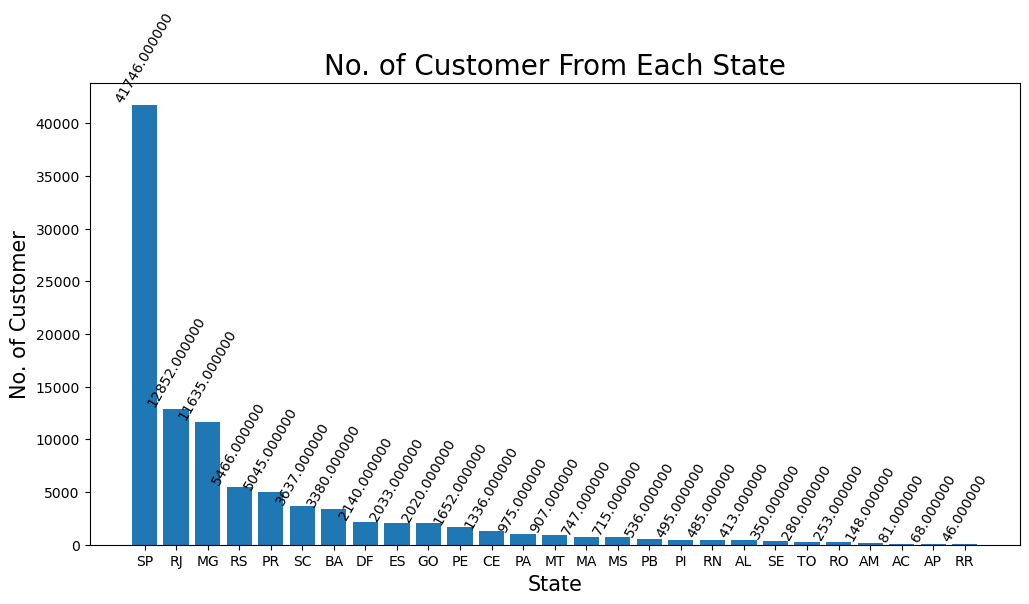

In [3]:
query = """ select customer_state, count(customer_id) from customer group by customer_state """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['State','No. of Customer'])
df = df.sort_values(by='No. of Customer',ascending=False)

plt.figure(figsize=(12,6))
plt.bar( df['State'], df['No. of Customer'])
plt.title('No. of Customer From Each State',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('No. of Customer',fontsize=15)

# Data Label
for index,value in enumerate(df['No. of Customer']):
    plt.text( index, value, f'{value:0f}', va='bottom', ha='center', rotation=60)
    
plt.show()

### Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders 
            where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
print('Total Order Placed In 2017 :', data[0][0])

Total Order Placed In 2017 : 45101


### Find the total sales per category.

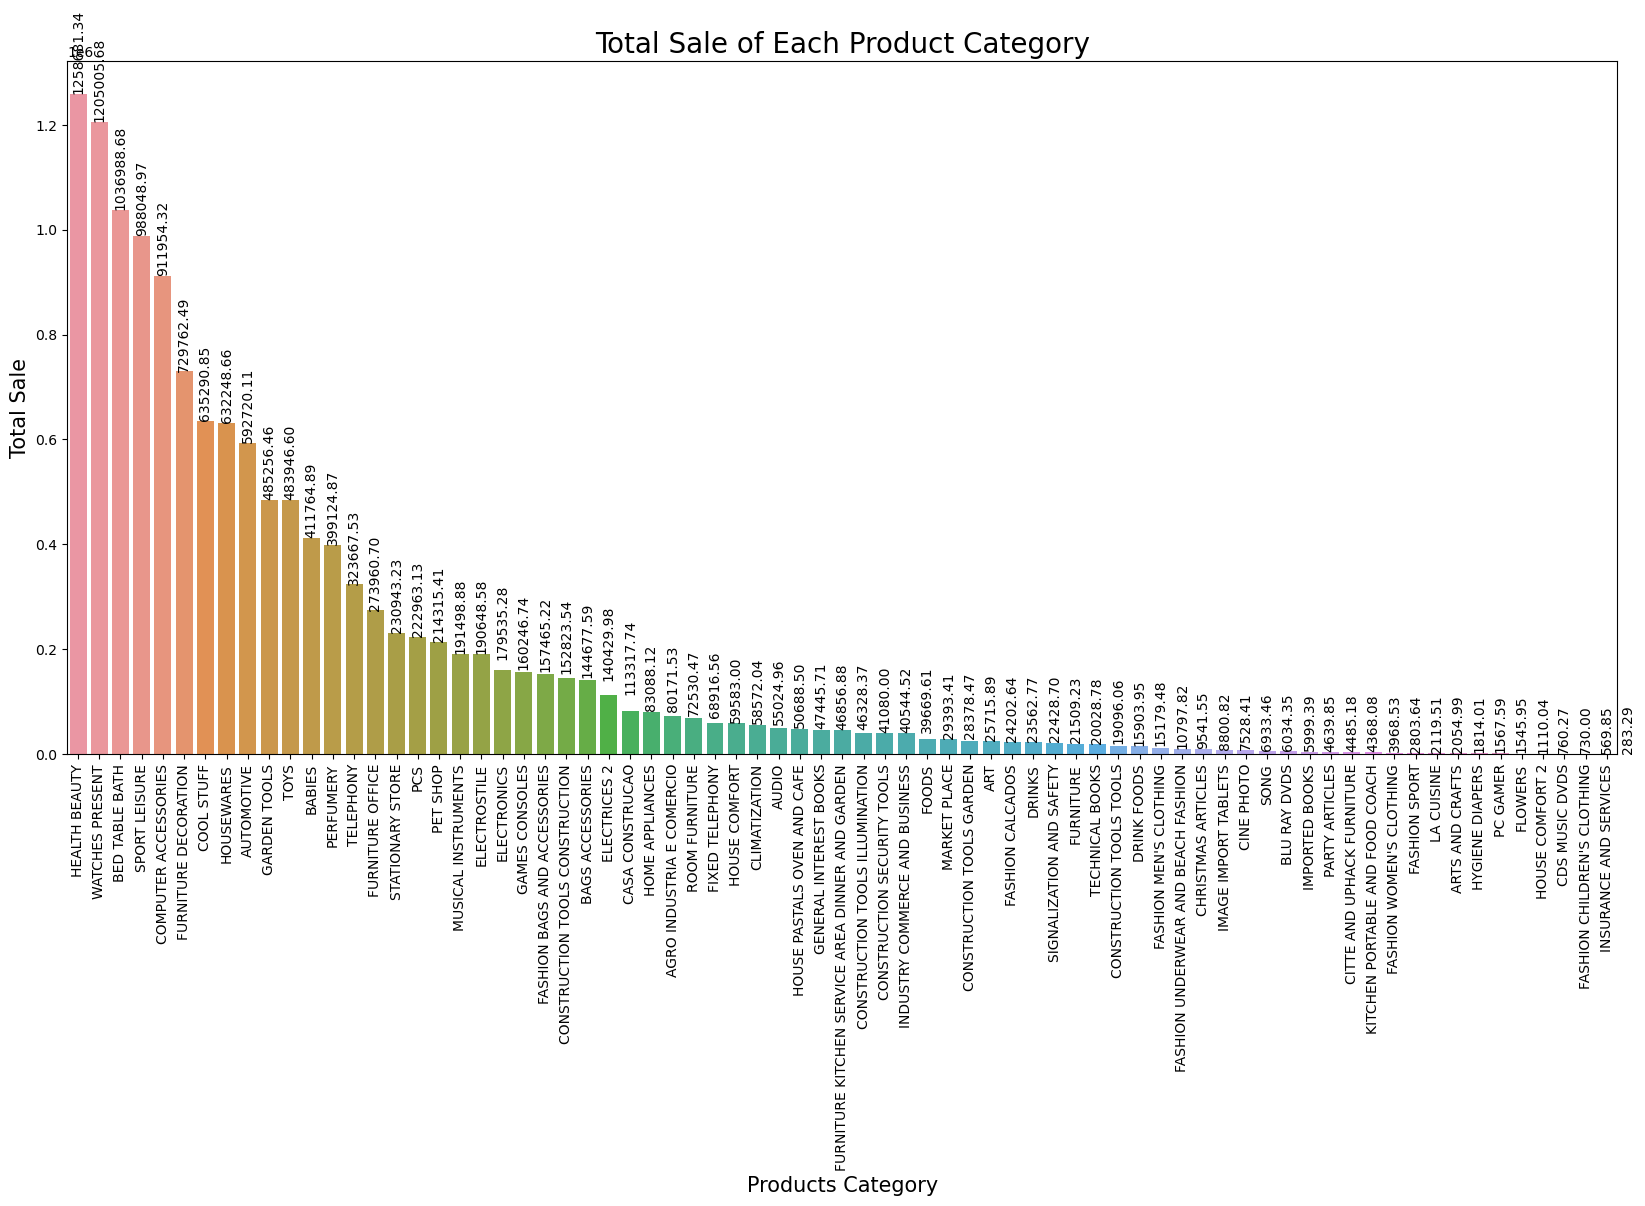

In [5]:
query = """ select upper(products.product_category), round(sum(order_items.price),2) as total_sales
            from products join order_items 
            on products.product_id = order_items.product_id
            group by products.product_category"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Products Category','Total Sale'])
df = df.sort_values(by = 'Total Sale', ascending=False)

plt.figure(figsize=(20,9))
sns.barplot(x='Products Category', y='Total Sale', data=df)
plt.title('Total Sale of Each Product Category', fontsize=20)
plt.xlabel('Products Category', fontsize=15)
plt.ylabel('Total Sale', fontsize=15)
plt.xticks(rotation=90)

# Data Label 
for index, value in enumerate(df['Total Sale']):
    plt.text(index,value,f'{value:0.2f}', va='bottom', ha='center', rotation=90)
plt.show()


### Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ select sum(case when payment_installments >=1 then 1 else 0 end)*100/count(*) 
            from payments"""

cur.execute(query)
data = cur.fetchall()

data

[(Decimal('99.9981'),)]

### Calculate the number of orders per month in 2018.

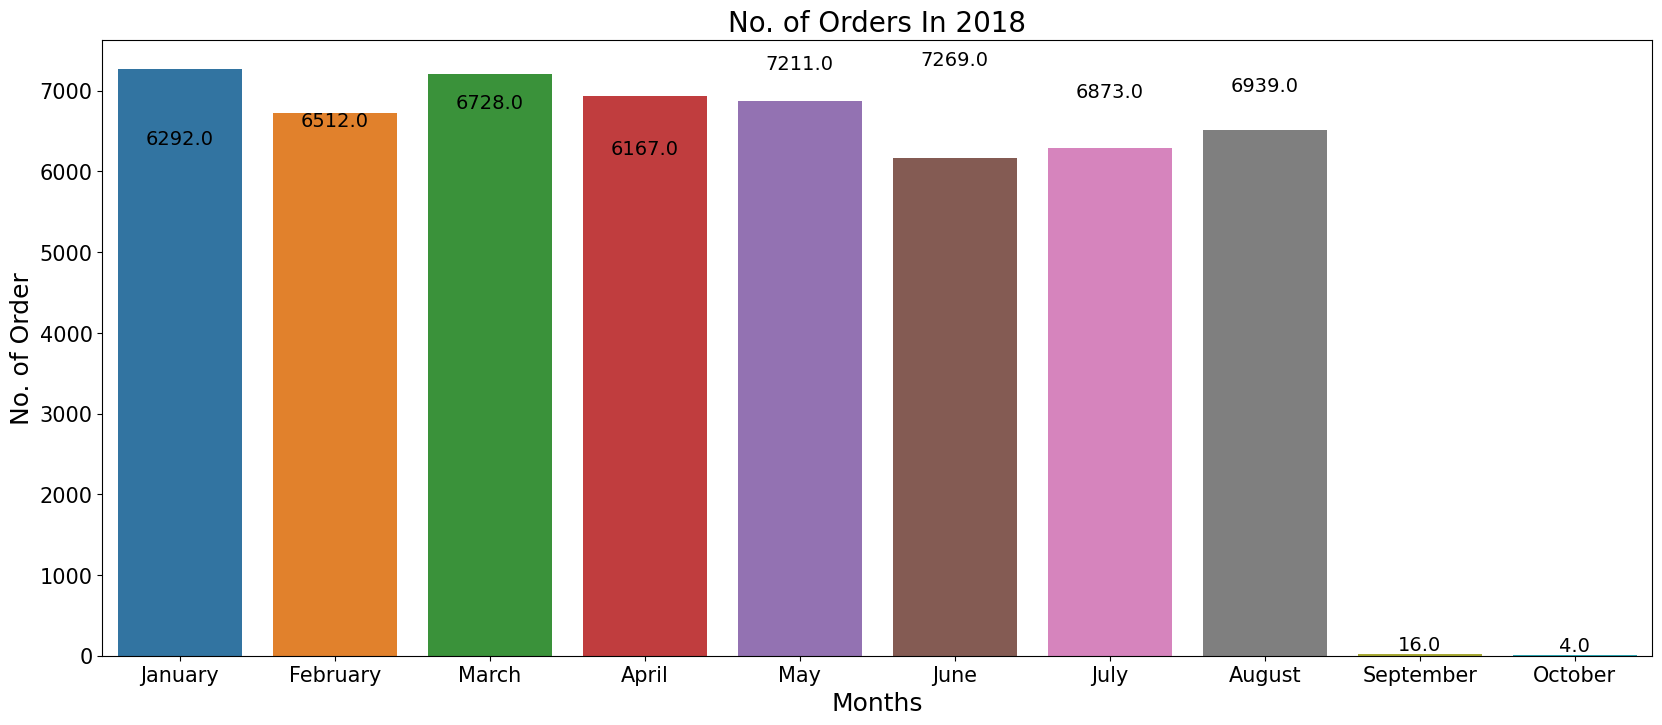

In [7]:
query = """ select monthname(order_purchase_timestamp), count(order_id) 
            from orders 
            where year(order_purchase_timestamp)= 2018
            group by monthname(order_purchase_timestamp)"""
cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data,columns=['Months','No. of Order'])
ordr = ['January','February','March','April','May','June','July','August','September','October']

plt.figure(figsize=(20,8))
sns.barplot(x='Months',y= 'No. of Order',data = df, order=ordr)
plt.title('No. of Orders In 2018',fontsize=20)
plt.xlabel('Months',fontsize=18)
plt.ylabel('No. of Order', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Data label
for index,value in enumerate(df['No. of Order']):
    plt.text(index,value, f'{value:0.1f}', va='bottom', ha='center', fontsize=14)
    
plt.show()

### Find the average number of products per order, grouped by customer city.

In [8]:
query = """ with count_per_order as
            (select orders.order_id, orders.customer_id, count(order_items.order_id)  as oc
            from orders join order_items
            on orders.order_id = order_items.order_id
            group by  orders.order_id, orders.customer_id)
            
            select upper(customer.customer_city), 
            round(avg(count_per_order.oc),2) as avg
            from customer join count_per_order
            on customer.customer_id = count_per_order.customer_id
            group by customer.customer_city 
            order by avg desc"""

cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=['City','Average_order'])
df.head(10)

,City,Average_order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,DATAS,6.00
3,CANDIDO GODOI,6.00
4,MATIAS OLIMPIO,5.00
5,MORRO DE SAO PAULO,4.00
6,TEIXEIRA SOARES,4.00
7,CURRALINHO,4.00
8,CIDELANDIA,4.00
9,PICARRA,4.00


### Calculate the percentage of total revenue contributed by each product category.


In [25]:
query = """ select upper(products.product_category),
            round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as total_sales
            from products join order_items 
            on products.product_id = order_items.product_id
            join payments 
            on payments.order_id = order_items.order_id
            group by products.product_category
            order by total_sales desc"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Product Category','Revenue'])
df

,Product Category,Revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


<Figure size 2000x800 with 0 Axes>

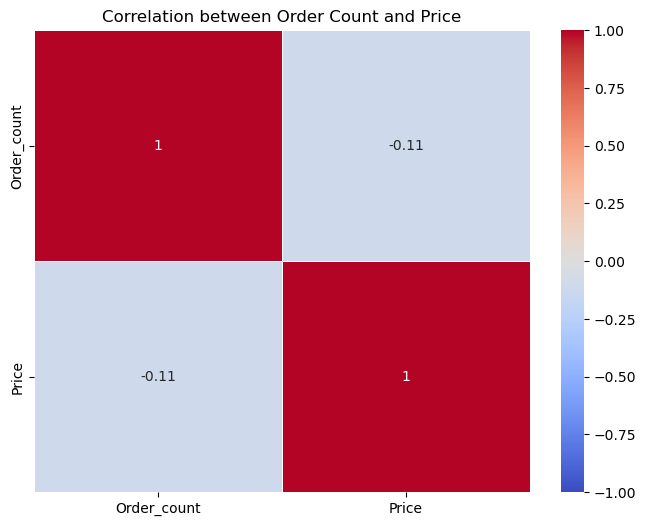

In [10]:
query = """ select upper(products.product_category) as category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products 
join order_items
on products.product_id = order_items.product_id
group by category"""

cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns=['Category','Order_count','Price'])

plt.figure(figsize=(20,8))
# Compute the correlation matrix
corr_matrix = df[['Order_count', 'Price']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Order Count and Price')
plt.show()

### Calculate the total revenue generated by each seller, and rank them by revenue.

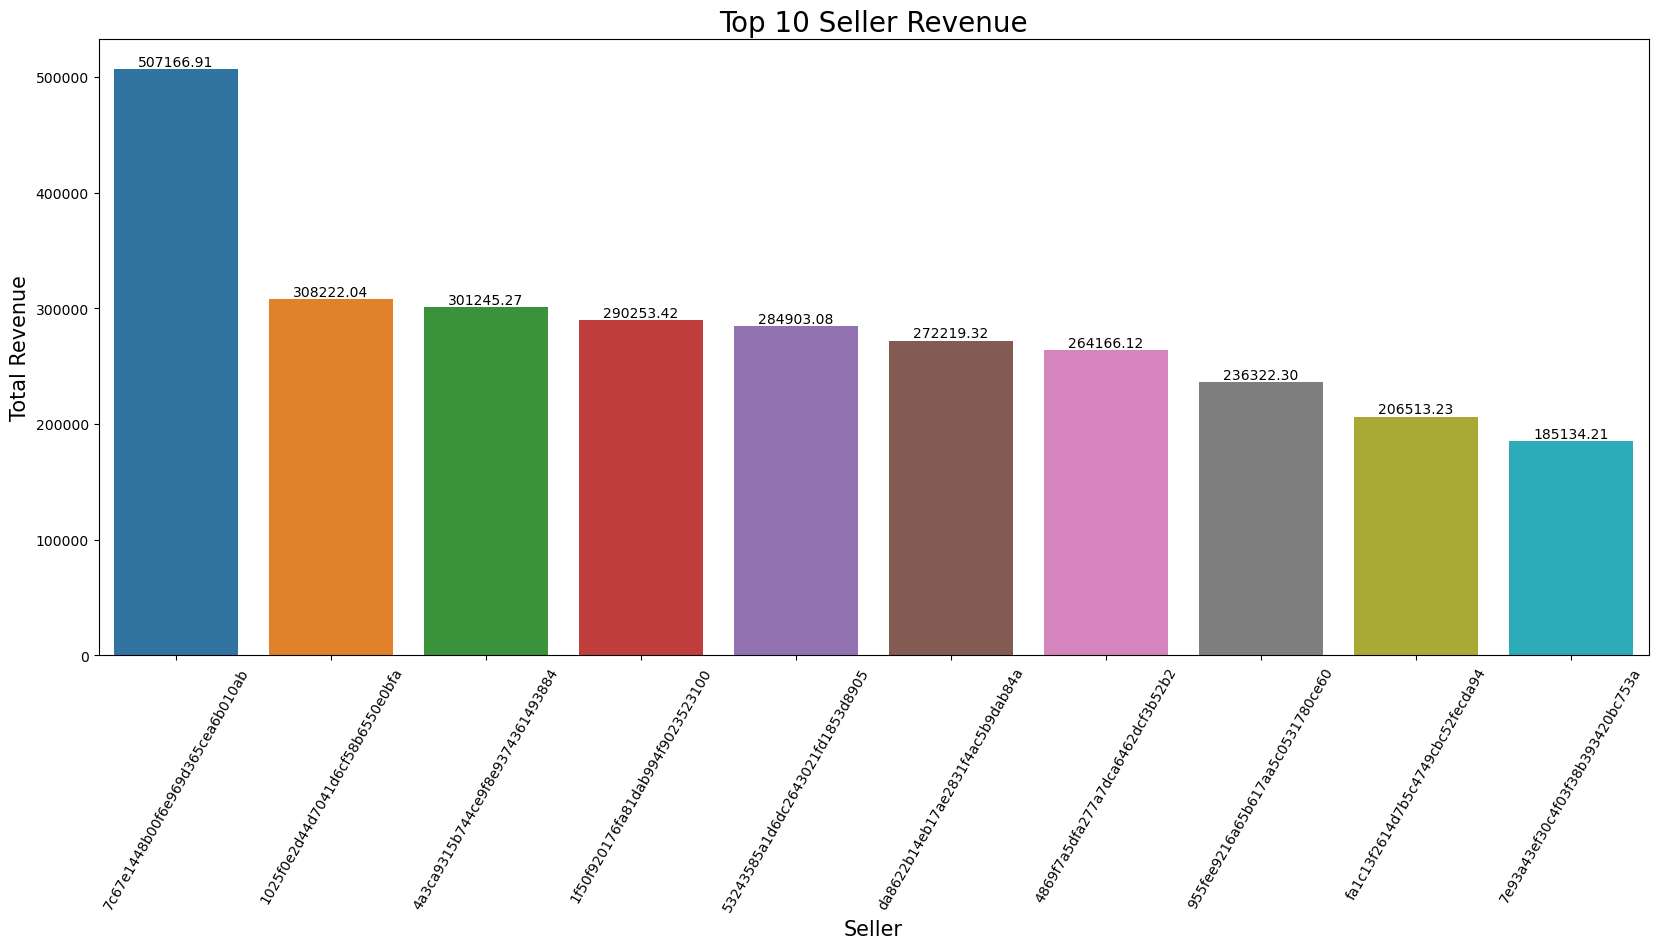

In [40]:
query = """ select * , 
            dense_rank() over(order by revenue desc) as 'rank' 
            from(
            select order_items.seller_id, 
            sum(payments.payment_value) as revenue
            from order_items 
            join payments
            on order_items.order_id = payments.order_id
            group by order_items.seller_id) as ss  """



cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data, columns=['Seller','Total Revenue','Rank'])
df = df.head(10)

plt.figure(figsize=(20,8))
sns.barplot(x='Seller', y='Total Revenue', data=df)
plt.title('Top 10 Seller Revenue', fontsize=20)
plt.xlabel('Seller',fontsize=15)
plt.ylabel('Total Revenue',fontsize=15)
plt.xticks(rotation=60)

# Data Label 
for index,value in enumerate(df['Total Revenue']):
    plt.text(index,value, f'{value:0.2f}', va='bottom', ha='center')
plt.show()

### Calculate the moving average of order values for each customer over their order history.

In [53]:
query = """ 
select customer_id, order_purchase_timestamp, payment, 
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as 'mov_avg'
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from orders
join payments
on orders.order_id = payments.order_id) as ss
"""
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns=['Customer_id','Order Purchase TimeStamp','Payment','Moving Average'])
df

,Customer_id,Order Purchase TimeStamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### Calculate the cumulative sales per month for each year.

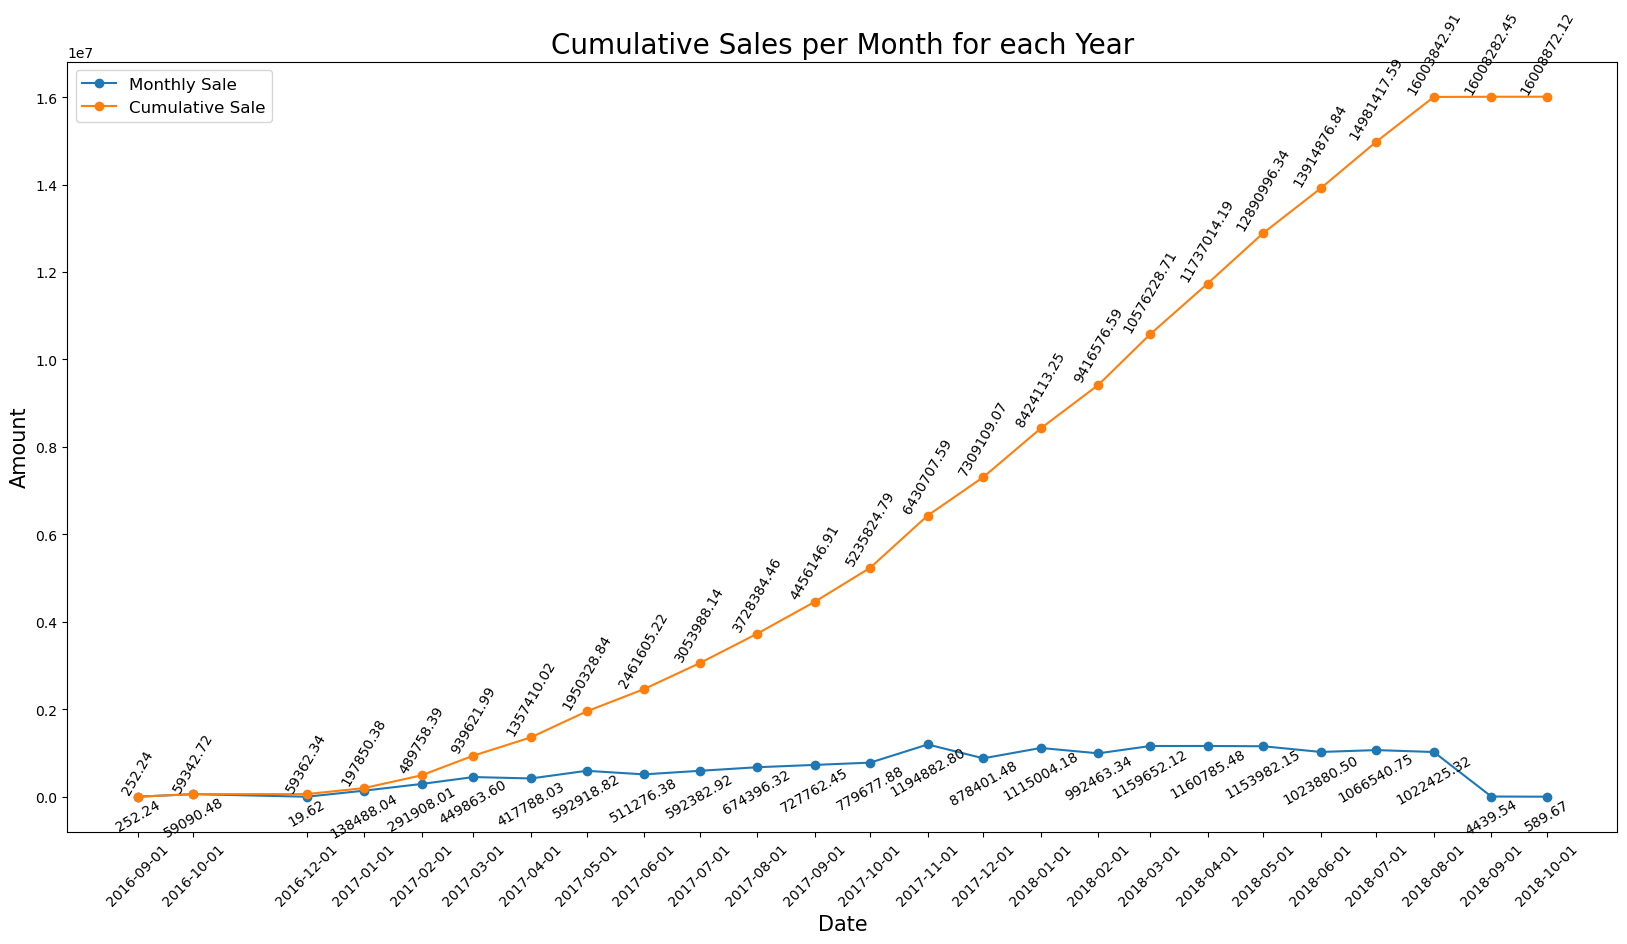

In [82]:
query = """ select years, months, payment, 
round(sum(payment) over(order by years, months),2) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months ,
round(sum(payments.payment_value),2) as payment
from orders 
join payments
on orders.order_id = payments.order_id
group by years,months 
order by years, months)as ss """

cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=['Year','Month','Sale','Cumulative Sale'])

df['Date']=  pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
df.set_index('Date', inplace=True)

plt.figure(figsize=(20,10))
plt.plot(df.index, df['Sale'], marker='o', label='Monthly Sale')
# Data label
for i, value in enumerate(df['Sale']):
    plt.text(df.index[i],value, f'{value:0.2f}', va='top',ha='center', rotation=30)
    
plt.plot(df.index, df['Cumulative Sale'], marker='o', label='Cumulative Sale')
#Data label
for i, value in enumerate(df['Cumulative Sale']):
    plt.text(df.index[i],value, f'{value:0.2f}', va='bottom',ha='center', rotation=60)
    
plt.title('Cumulative Sales per Month for each Year',fontsize=20)
plt.xlabel('Date', fontsize= 15)
plt.ylabel('Amount', fontsize= 15)
plt.xticks(df.index, rotation=45)
plt.legend(fontsize=12)
plt.show()

### Calculate the year-over-year growth rate of total sales.

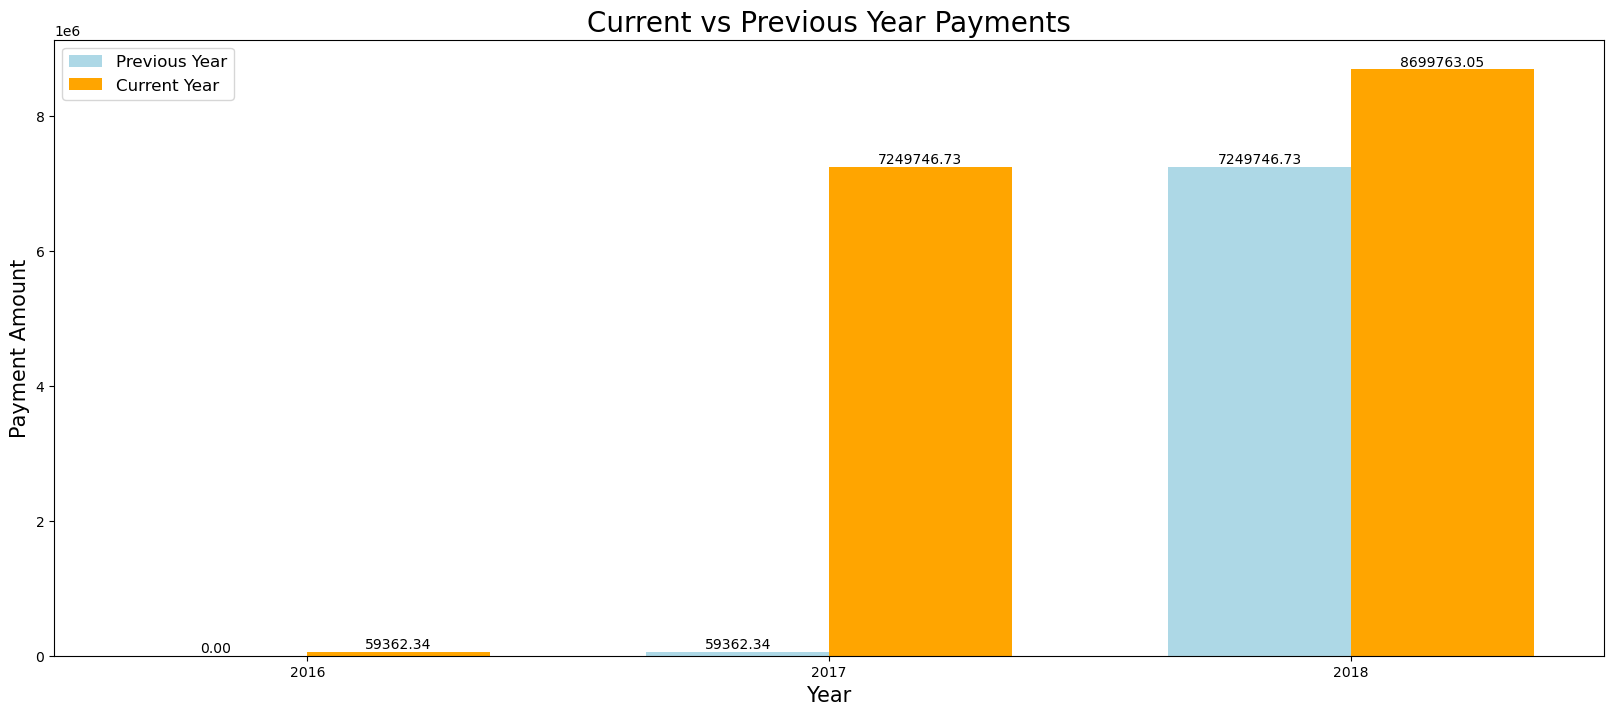

In [111]:
query =""" select years, current_year, 
lag(current_year,1) over(order by years ) as previous_year from 
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as current_year
from orders
join payments
on orders.order_id = payments.order_id
group by years 
order by years) as ss;"""

cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data,columns=['Year','Current Year','Previous Year'])
df= df.fillna(0)

plt.figure(figsize=(20,8))
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(df['Year']))
plt.bar(x, df['Previous Year'], width=bar_width, label='Previous Year', color='lightblue')
plt.bar(x + bar_width, df['Current Year'], width=bar_width, label='Current Year', color='orange')
# Data label
for i in range(len(df)):
    plt.text(i, df['Previous Year'][i], f'{df["Previous Year"][i]:.2f}', ha='center', va='bottom')
    plt.text(i + bar_width, df['Current Year'][i], f'{df["Current Year"][i]:.2f}', ha='center', va='bottom')
    
plt.xlabel('Year', fontsize=15)
plt.ylabel('Payment Amount', fontsize=15)
plt.title('Current vs Previous Year Payments',fontsize=20)
plt.xticks(x + bar_width / 2, df['Year'])
plt.legend(fontsize=12)
plt.show()

### Identify the top 3 customers who spent the most money in each year.

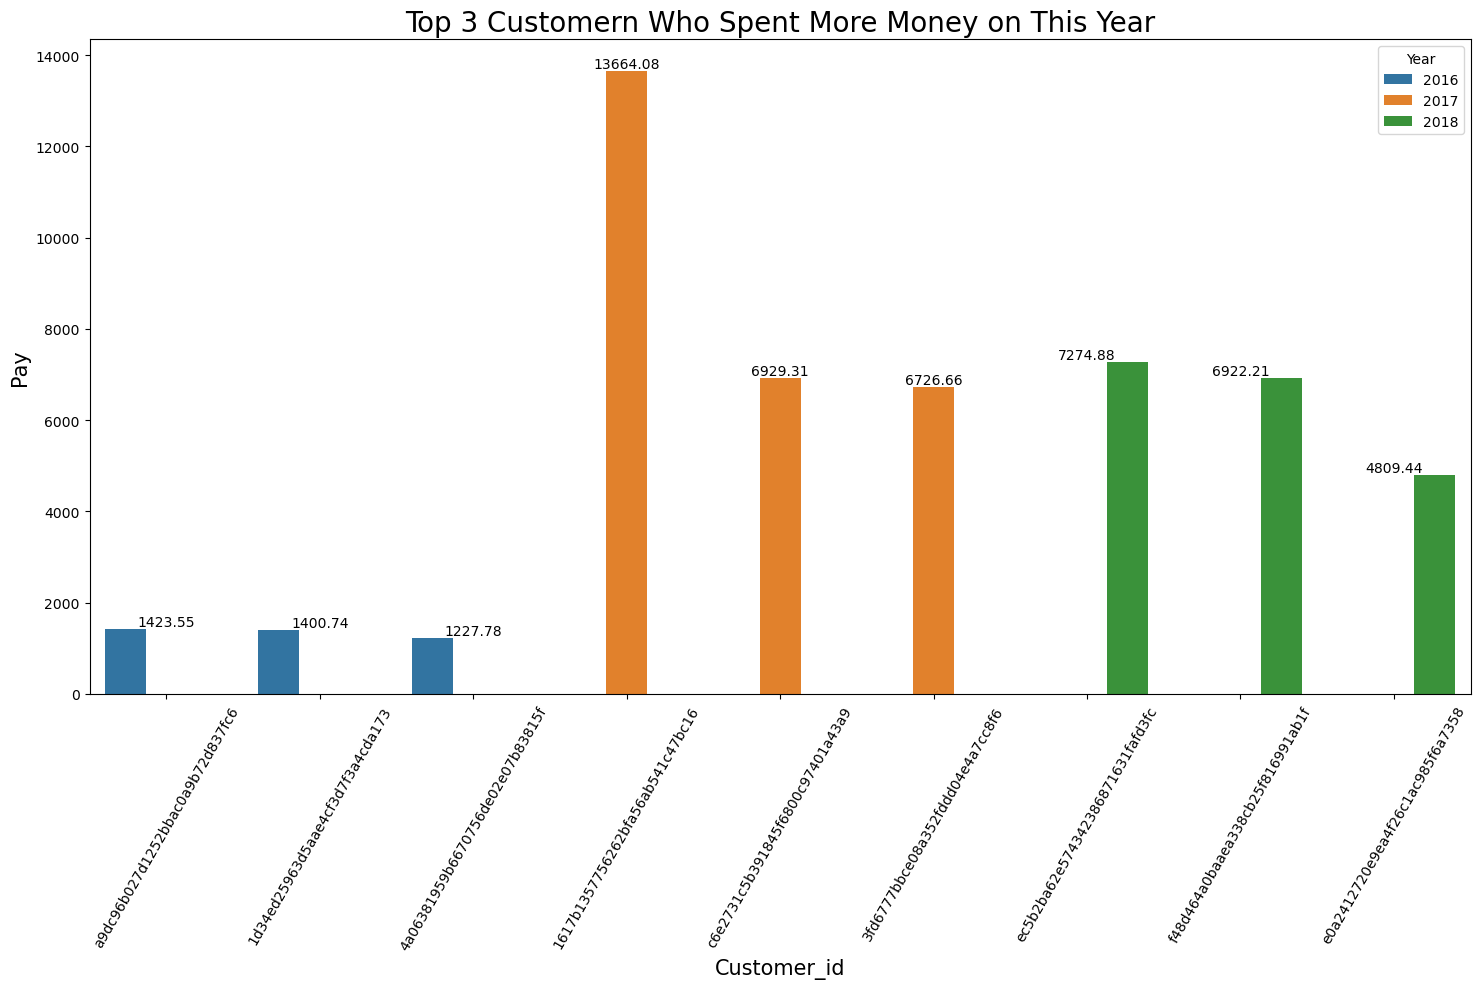

In [124]:
query=""" select years, customer_id, payment from 
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank
from orders
join payments
on orders.order_id = payments.order_id
group by years, orders.customer_id ) as ss
where d_rank<= 3
"""

cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns=['Year','Customer_id','Pay'])
df

plt.figure(figsize=(15,10))
sns.barplot(x='Customer_id', y='Pay', data=df, hue='Year')
plt.title('Top 3 Customern Who Spent More Money on This Year', fontsize=20)
plt.xlabel('Customer_id',fontsize=15)
plt.ylabel('Pay',fontsize=15)
plt.xticks(rotation=60)

# Data Label 
for index,value in enumerate(df['Pay']):
    plt.text(index,value, f'{value:0.2f}', va='bottom', ha='center')
    
plt.tight_layout()
plt.show()